<a href="https://colab.research.google.com/github/viviakemik/machine-learning/blob/main/trees/ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Book: 

* Hands-on Machine Learning with Scikit-learn & TensorFlow

https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646

2. Github: https://github.com/ageron/handson-ml2

3. Courses: 
* https://www.coursera.org/learn/ml-classification/home
* https://learning.edx.org/course/course-v1:UCSanDiegoX+DSE220x+1T2021/home

4. Youtube:
* https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

A group of predictors is called an ensemble, based on wisdom of the crowd.

# **Voting Classiers**

Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails.

If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%.

This is due to the **law of large numbers**: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

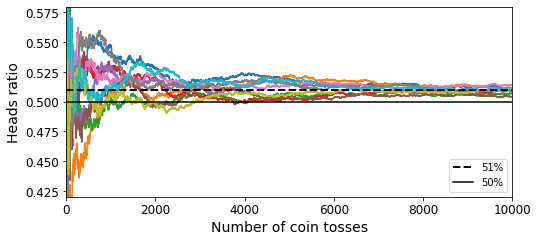

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
#save_fig("law_of_large_numbers_plot")
plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy!

Somewhat surprisingly, this voting classifier often **achieves a higher accuracy than the best classifier in the ensemble**.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., they have a **predict_proba()** method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It **often achieves higher performance** than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with **voting="soft"**

In SVC you need to set probability = true (and then use predict_proba())

In [8]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


* In hard voting (also known as majority voting), every individual classifier votes for a class, and the majority wins.
* In soft voting, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. 

# **Bagging and Pasting**

* When sampling is performed **with replacement**, this method is called **bagging** (short for bootstrap aggregating). Bootstrapping introduces a bit more diversity in the subsets (slightly higher bias than pasting)
* When sampling is performed **without replacement**, it is called **pasting**.
* You can use cross-validation to choose

predictors can all be trained in parallel, via different
CPU cores or even different servers.

Source: https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646

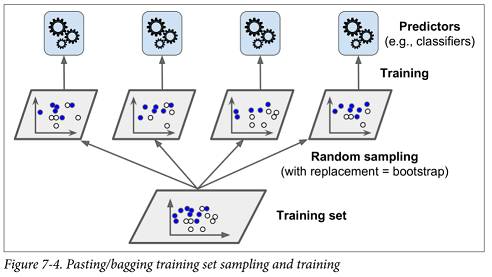




Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply **aggregating the predictions of all predictors.** The aggregation function is typically the **statistical mode**

## **Bagging and Pasting in Scikit-Learn**

* set with replacement (this is an example of bagging,
but if you want to use pasting instead, just set bootstrap=False). The n_jobs parameter tells Scikit-Learn the number of CPU cores.

* The BaggingClassifier automatically performs soft voting

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

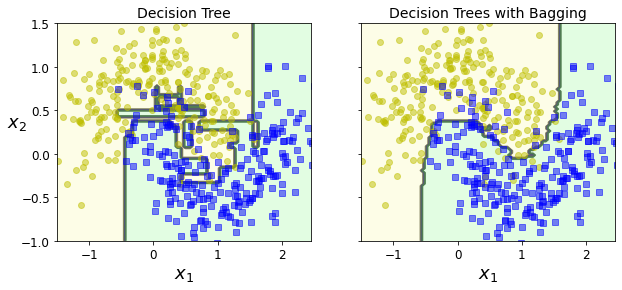

In [14]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Figure Right: lower variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular).

# **Out-of-Bag evaluation**

* with replacement (bootstrap=True), where m is the size of the
training set. 

* This means that only about 63% of the training instances are sampled on average for each predictor. The remaining **37%** of the training instances that **are not sampled are called out-of-bag** (oob) instances 

* set oob_score=True when creating a BaggingClassifier to
request an automatic oob evaluation after training.

* Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set.

https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

in cases where we do not have a large dataset and want to consume it all as the training dataset, the OOB score provides a good trade-off.

https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=6s


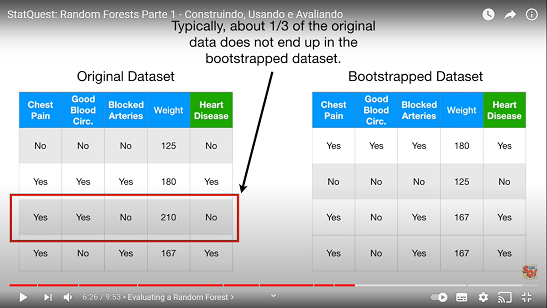

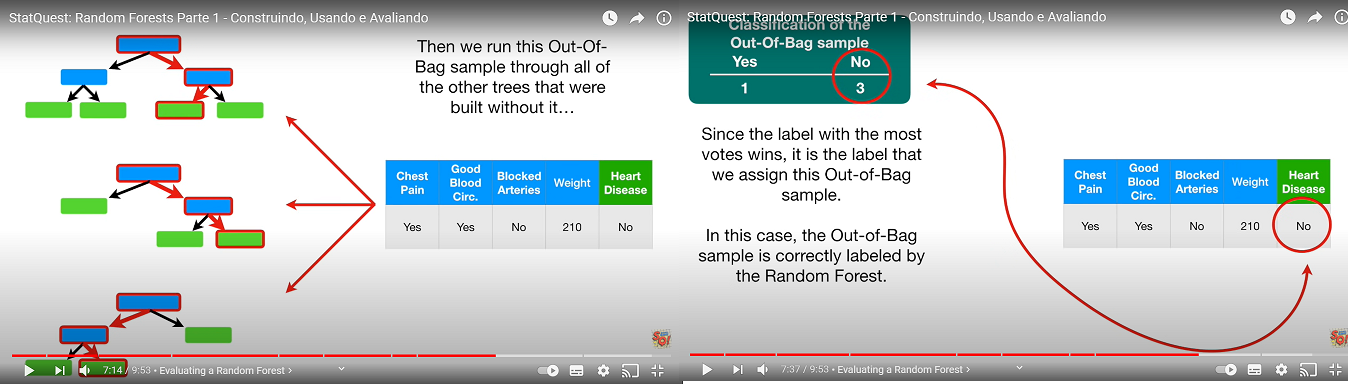

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [16]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## **Random Patches and Random Subspaces**

The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: **max_features** and **bootstrap_features**.

* useful when you are dealing with high-dimensional inputs
* Sampling features results in even more predictor diversity (more bias for a lower variance)

# **Random Forests**

* Random Forest is an **ensemble of Decision Trees** (To reduce the risk of overfitting, models that combine many decision trees are preferred)

* Generally trained via the **bagging** method (or sometimes pasting), typically with max_samples set to the size of the training set.

**Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier**, you can instead use the **RandomForestClassifier**
class (has all the hyperparameters to control how trees are grown, plus all the hyperparameters of a BaggingClassifier to control the ensemble), which is more convenient and optimized for Decision Trees

https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=6s

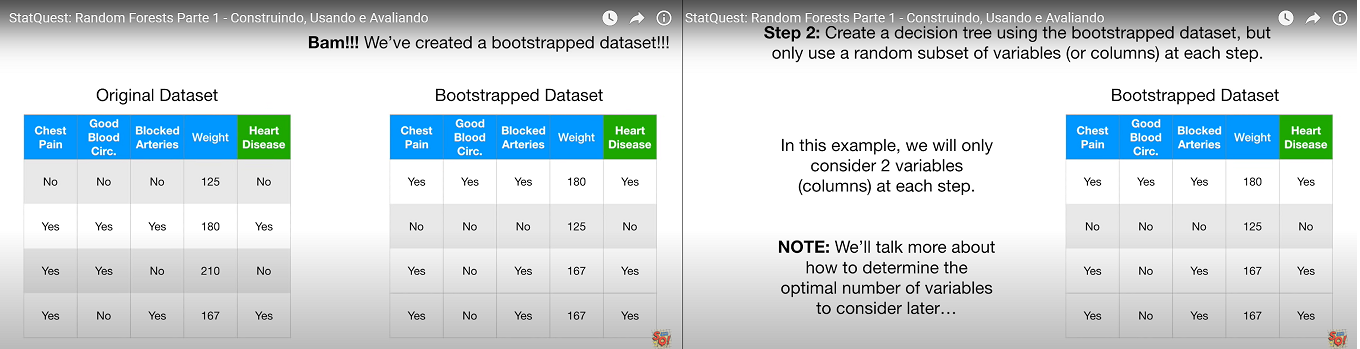

How to predict? Use out of bags instances and majority vote

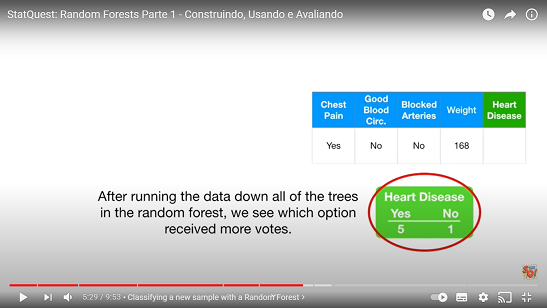

Estimate accuracy using **out of bags** and then build random forest again
Typically start using the square of the number of variables

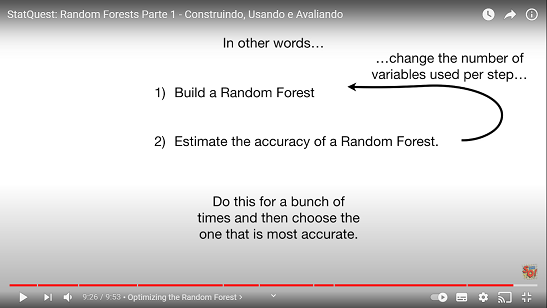

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [19]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Equivalently...

In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

instead of searching for the very best feature when splitting a node, it searches for the **best feature among a random subset of features**. This results in a greater tree **diversity**, which (once again) trades a higher bias for a lower variance,

## **Extra-trees**


A forest of such extremely random trees is simply called an **Extremely Randomized Trees** ensemble (using **random thresholds** for each feature). Once again, this trades more bias for a lower variance.

It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an **ExtraTreesClassifier**. Generally, the only way to know is to try both and compare them using cross-validation

# **Feature Importance**

Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [23]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

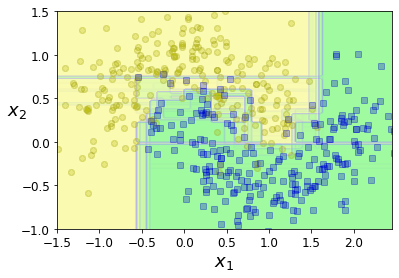

In [24]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

Similarly, if you train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance,

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

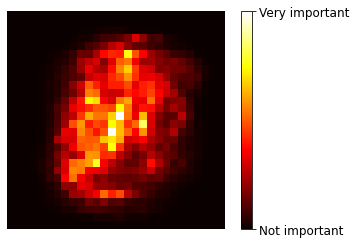

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#save_fig("mnist_feature_importance_plot")
plt.show()

# **Boosting**

* Boosting refers to any Ensemble method that can **combine several weak learners into a strong learner**. 

* The general idea of most boosting methods is to train predictors sequentially, each **trying to correct its predecessor**.

* Since trees are added sequentially, **boosting algorithms learn slowly**. In statistical learning, models that **learn slowly perform better**.

https://towardsdatascience.com/gradient-boosted-decision-trees-explained-9259bd8205af

Sources: https://www.coursera.org/learn/ml-classification/home
https://learning.edx.org/course/course-v1:UCSanDiegoX+DSE220x+1T2021/home

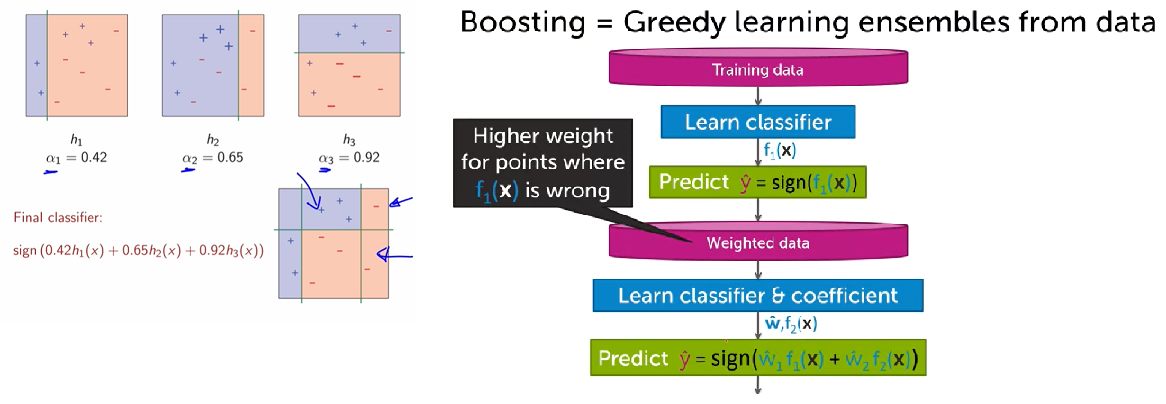

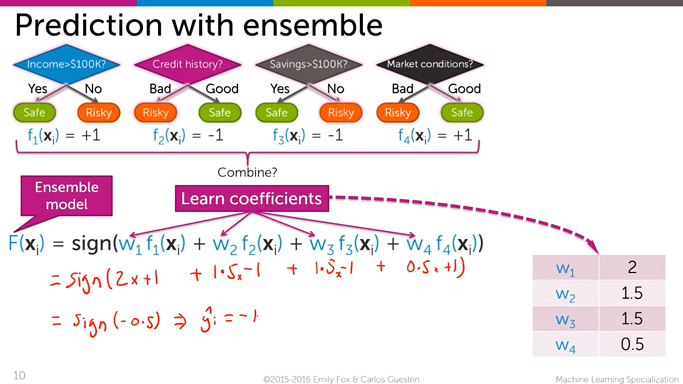

## **AdaBoost**

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted.


There is one important drawback to this sequential learning technique: it **cannot be parallelized**

Source: https://www.coursera.org/learn/ml-classification/home


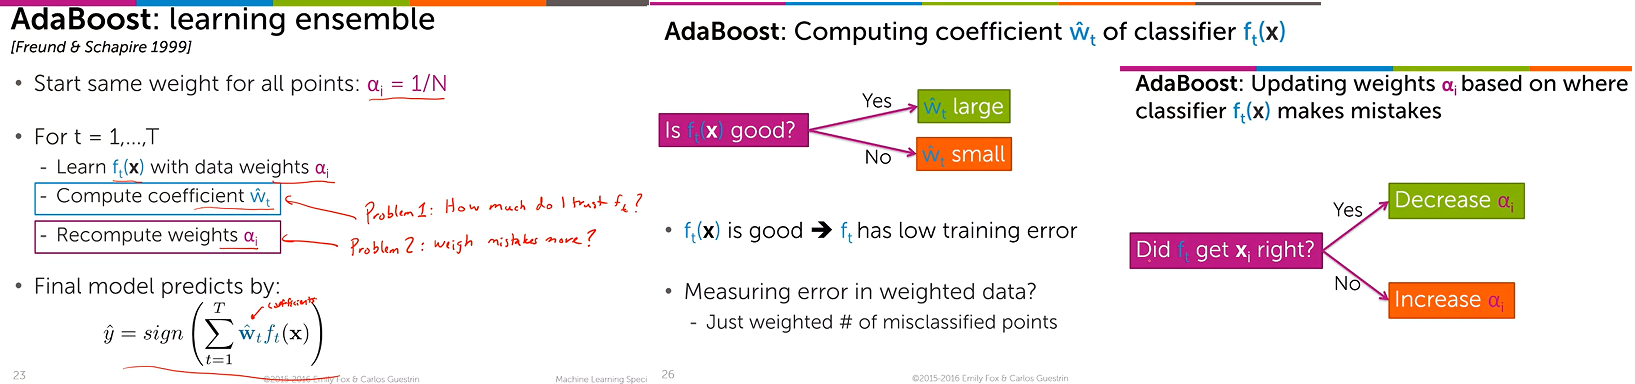

https://www.youtube.com/watch?v=LsK-xG1cLYA

Stumps

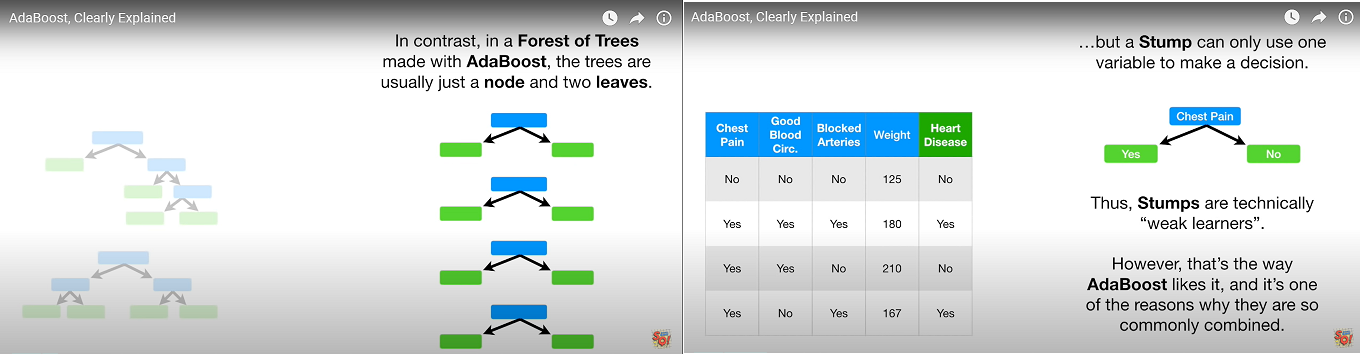

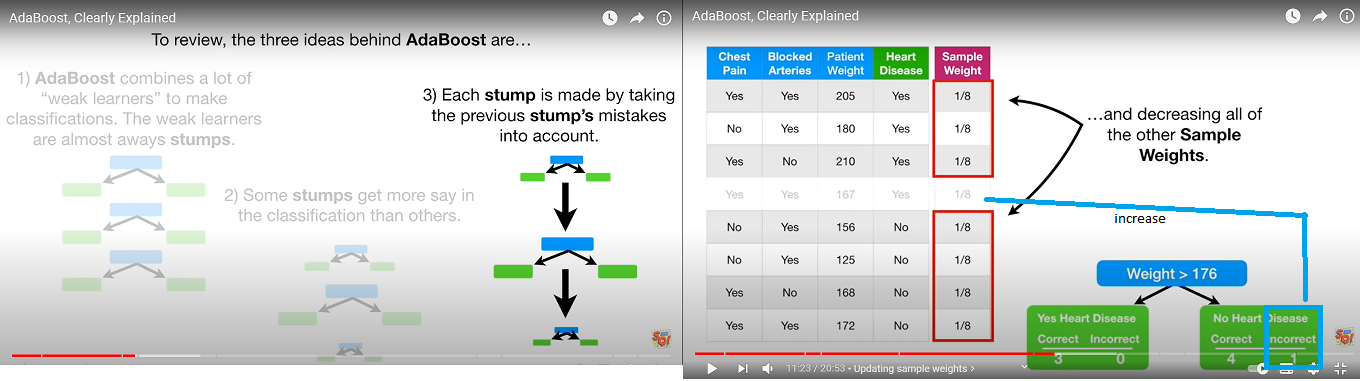

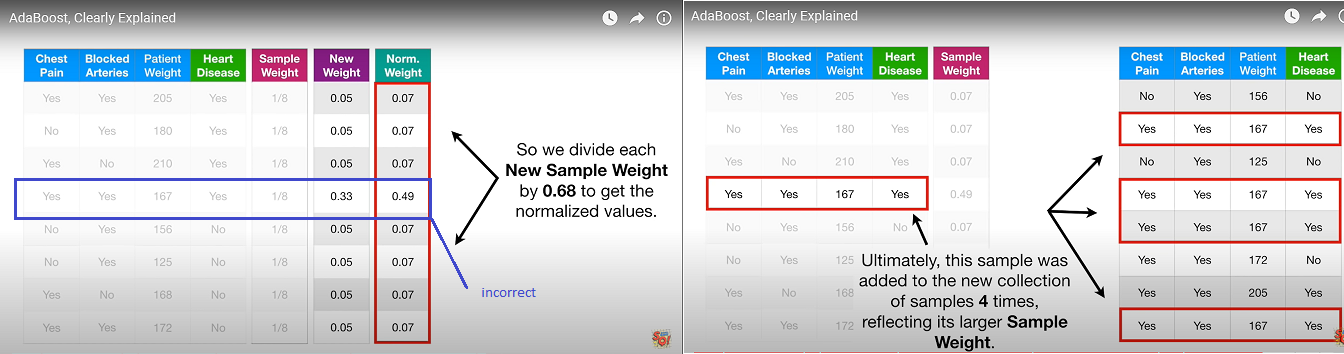

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME. if the
predictors can estimate class probabilities (i.e., if they have a predict_proba()
method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands
for “Real”), which relies on class probabilities rather than predictions and generally
performs better.

* A Decision Stump is a Decision Tree with **max_depth=1**

* If your AdaBoost ensemble is **overfitting** the training set, you can
try **reducing the number of estimators** (Increasing the number of trees in random forests does not cause overfitting, but here is different) or more **strongly regularizing the base estimator**.

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

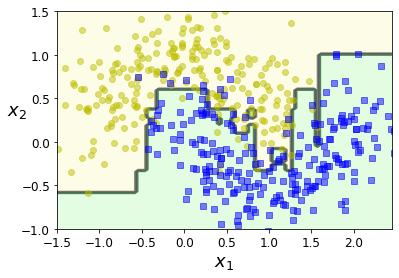

In [30]:
plot_decision_boundary(ada_clf, X, y)

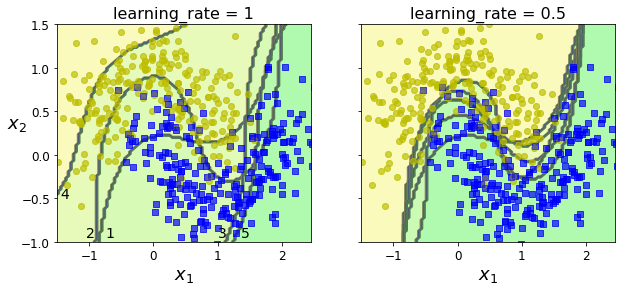

In [31]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

#save_fig("boosting_plot")
plt.show()

decision boundaries of five consecutive predictors on the moons dataset

# **Gradient Boosting**

Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method **tries to fit the new predictor to the residual errors made by the previous predictor**.

https://www.youtube.com/watch?v=3CC4N4z3GJc

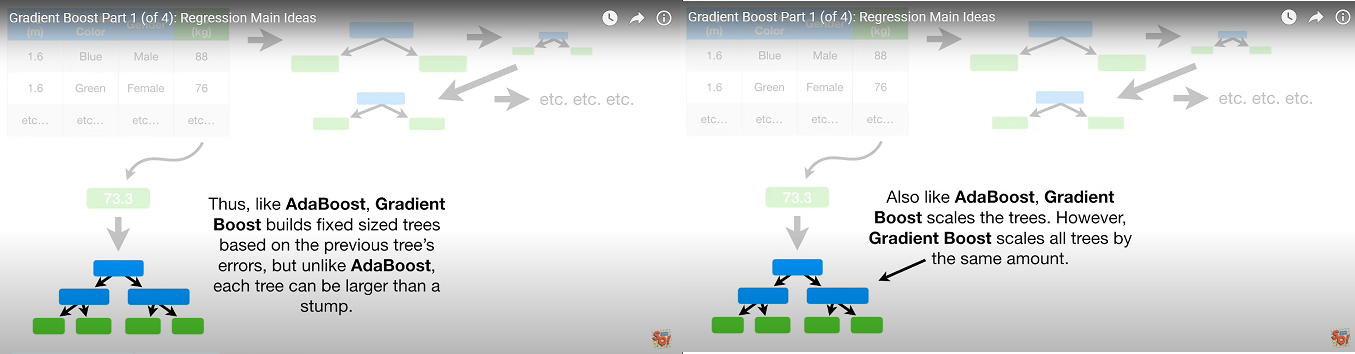

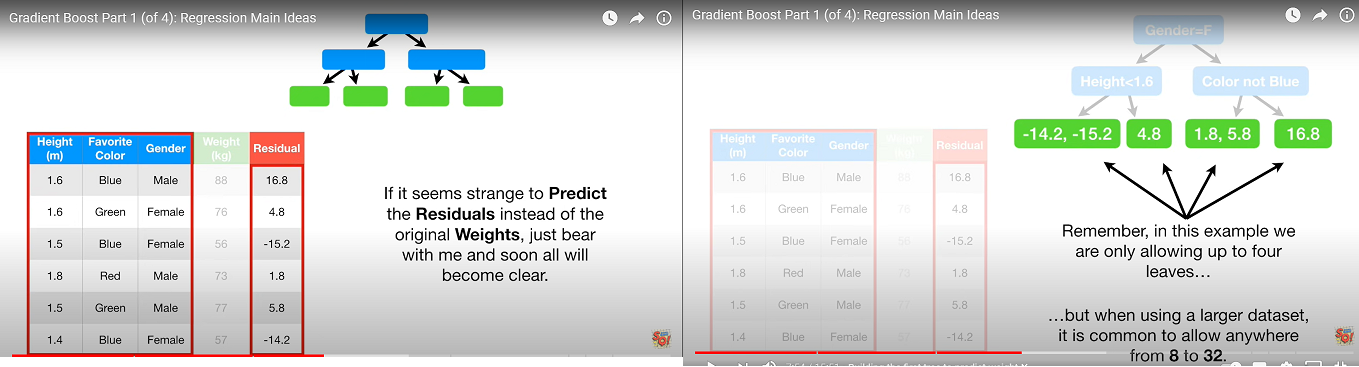

Prediction and Learning Rate

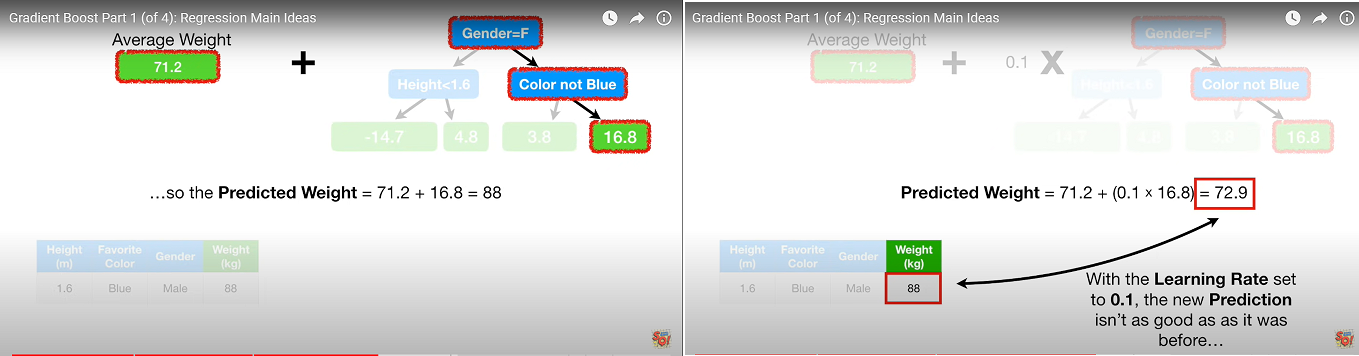

Second Tree (can be different from the first)

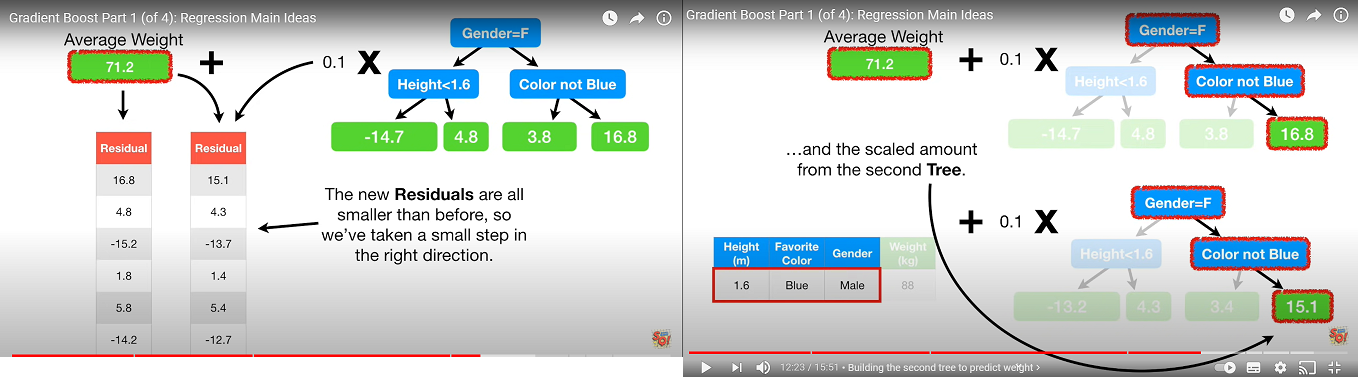

Let’s go through a simple regression example using Decision Trees as the base predictors

In [32]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [34]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:

In [35]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [36]:
X_new = np.array([[0.8]])

In [42]:
X_new.shape

(1, 1)

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [37]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([0.75026781])

In [39]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

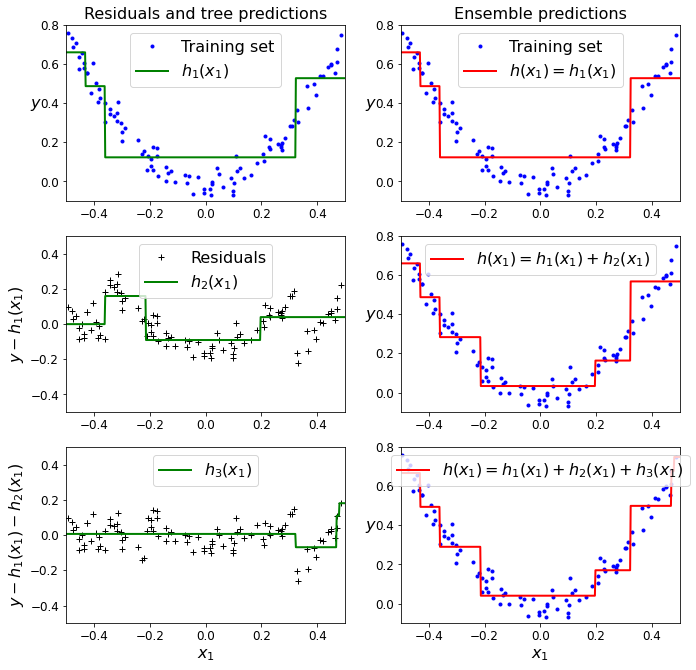

In [40]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

* In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions.

* In the second row, a new tree is trained on the residual errors of the first tree. 

* On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees.

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a **low value**, such as 0.1, **you will need more trees in the ensemble to fit the training set**, but the predictions will usually **generalize better**.


In [44]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

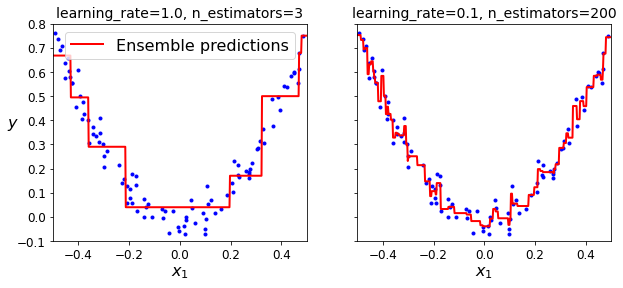

In [45]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

#save_fig("gbrt_learning_rate_plot")
plt.show()

the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

https://www.youtube.com/watch?v=2xudPOBz-vs

Loss Function

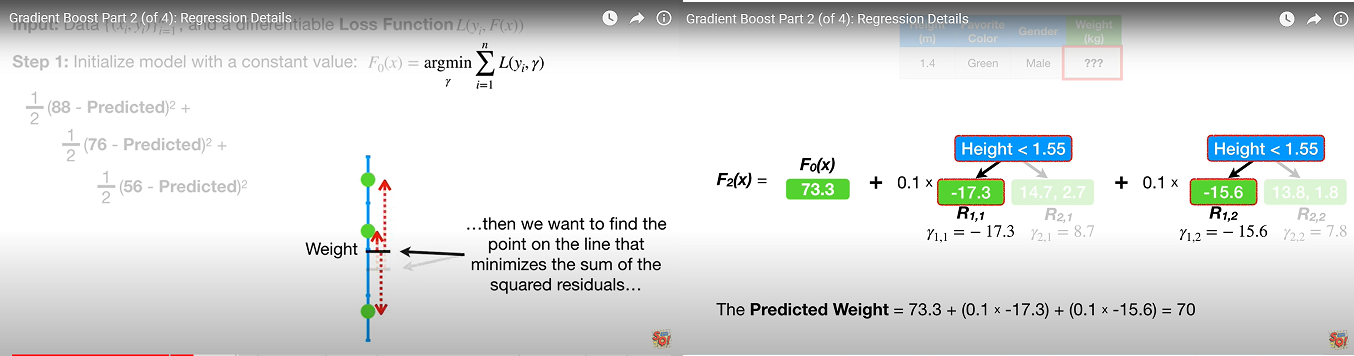

https://www.youtube.com/watch?v=jxuNLH5dXCs

Gradiente Boosting Classification

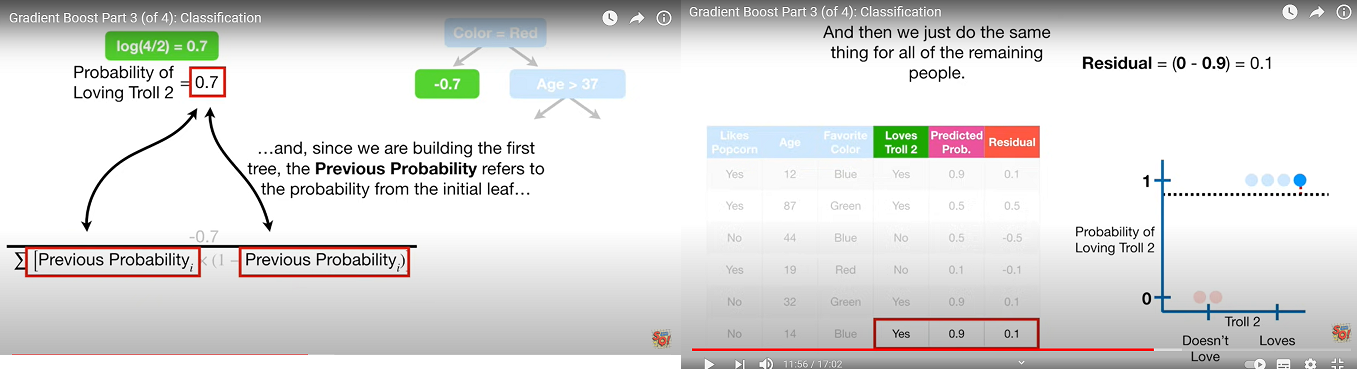

## **Gradient Boosting with Early stopping**

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the **staged_predict()**

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
min_error = np.min(errors)

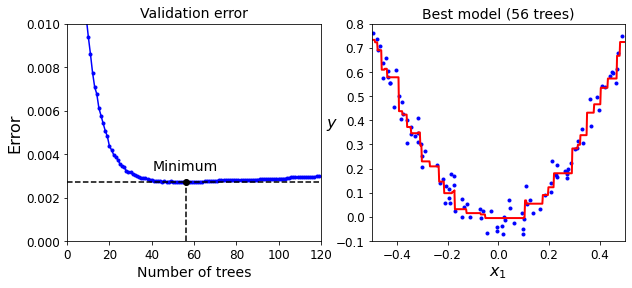

In [48]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

#save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early (warm_start=True). The following code stops training when the validation error does not
improve for five iterations in a row:

In [49]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [50]:
print(gbrt.n_estimators)

61


In [51]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## **Stochastic Gradient Boosting**

For ex, use subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly.

* speeds up training considerably
* high bias and low variance

# **XGBoost**

to use in a large and complex dataset (optimized implementation of Gradient Boosting)

https://www.youtube.com/watch?v=OtD8wVaFm6E

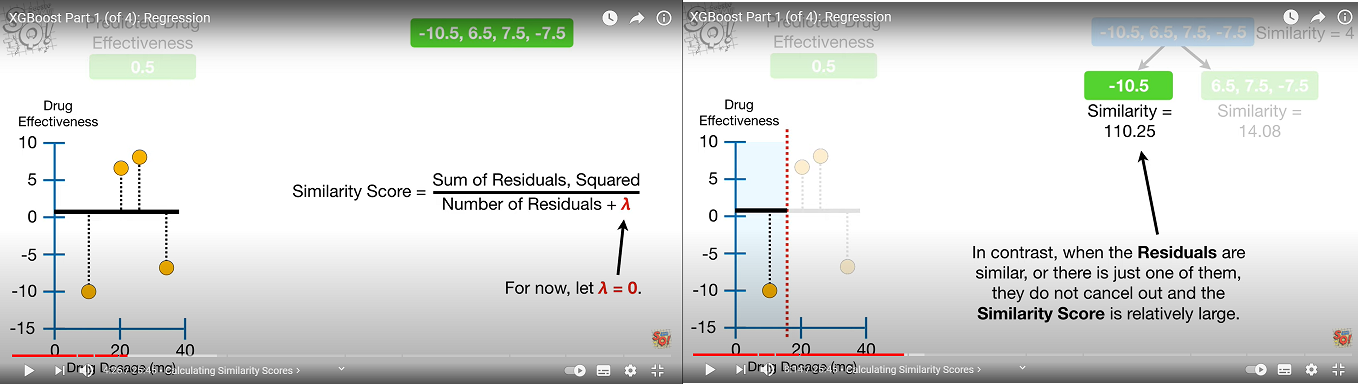

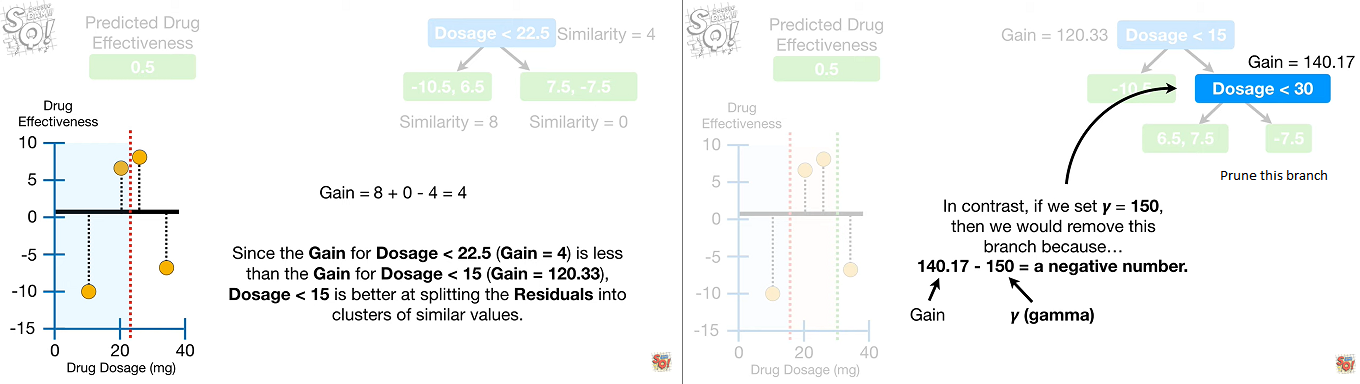

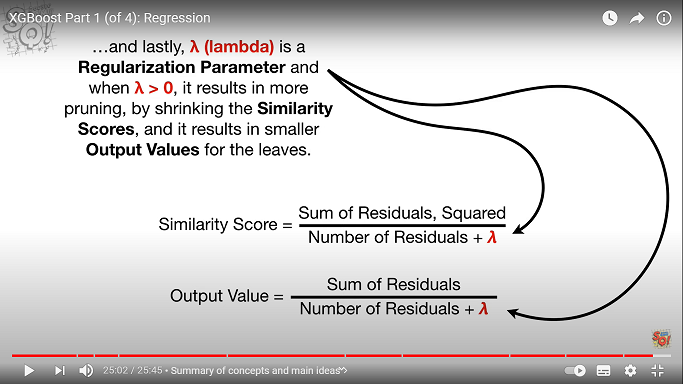

In [52]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [53]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

[11:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [54]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[11:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [55]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [56]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 23.7 ms per loop


# **Stacking**

https://machinelearningmastery.com/essence-of-stacking-ensembles-for-machine-learning/

* combine the predictions from two or more base machine learning algorithms (train a model to perform this aggregation, instead of using vote)
* generalization of a weighted average model
* be careful with [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/)
* Library that you can use https://github.com/viisar/brew
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# **Extra**

**Missing Values and Clustering**

* https://www.youtube.com/watch?v=nyxTdL_4Q-Q

* https://www.kaggle.com/sahilthegame123/randomforest-imputer

* Library that you can use Random Forest Imputer: https://medium.com/analytics-vidhya/automatic-missingvalueshandler-library-with-a-random-forest-d8d380da1fe0


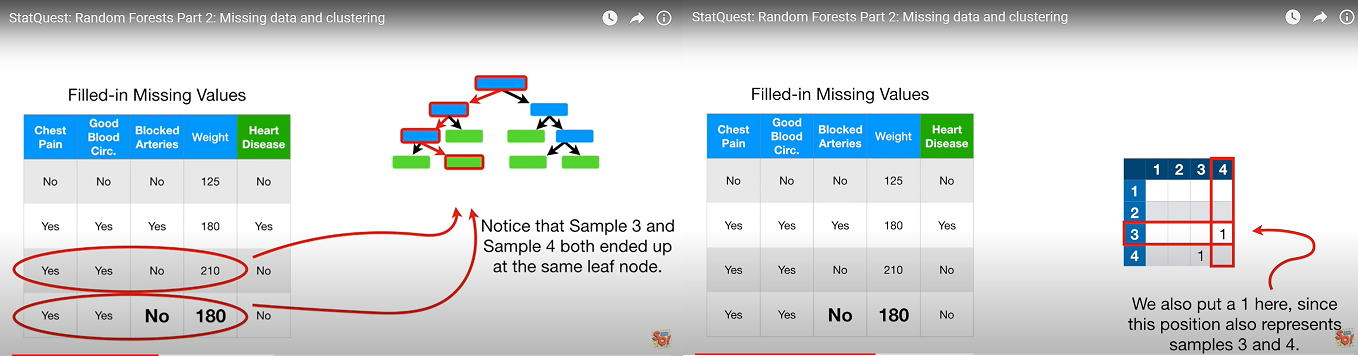


You can build MDS (multi-dimensional scaling) or HeatMap

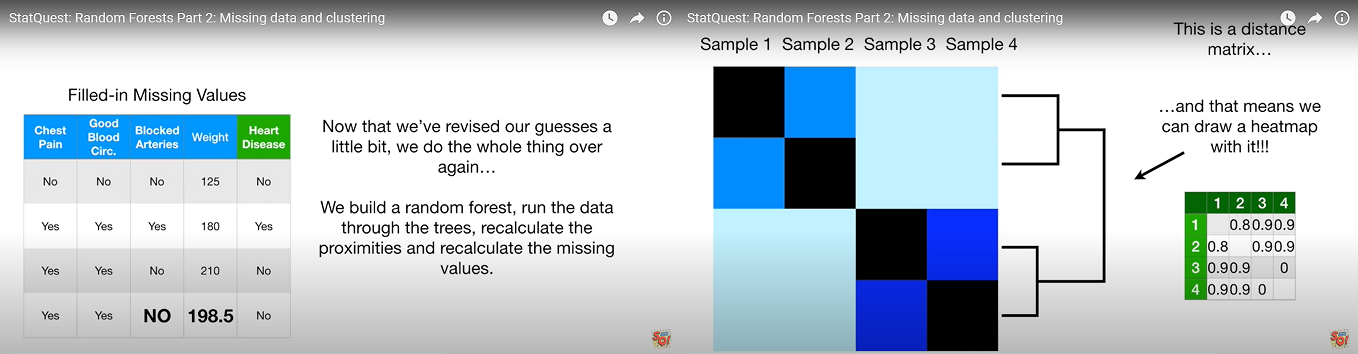

**XGBoost in Python**

https://www.youtube.com/watch?v=GrJP9FLV3FE

**Questions about Ensemble Modeling**

https://www.analyticsvidhya.com/blog/2017/02/40-questions-to-ask-a-data-scientist-on-ensemble-modeling-techniques-skilltest-solution/

# **Exercises**

## **1.**
If you have trained five different models on the exact same training data, and
they all achieve 95% precision, is there any chance that you can combine these
models to get better results? If so, how? If not, why?

See Voting Ensembles: works better with different models training on different instances 

## **2.**

What is the difference between hard and soft voting classifiers?

Hard voting: majority voting => individual classifier votes for a class, and the majority wins.

Soft voting: the target label with the greatest sum of weighted probabilities wins the vote.

## **3.**

Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?

* Boosting => No, each predictor is built based on the previous one
* Random Forest => Yes, each predictor is independent of the others
* Bagging and Pasting => Yes
* Stacking => Yes


## **4.**

What is the benefit of out-of-bag evaluation?

Not need validation set to do unbiased eval

## **5.**

What makes Extra-Trees more random than regular Random Forests? How can
this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?

Extra-Trees use a random threshold for each feature, instead of finding the best threshold. The randomness came from regularization (lambda).

## **6.**

If your AdaBoost ensemble underfits the training data, what hyperparameters
should you tweak and how?

* increase the number of estimators
* increase leaning rate
* reduce regularization of the base estimator

## **7.**

If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

The lower the learning rate, the slower the model learns. The advantage of slower learning rate is that the model becomes more robust and generalized.

## **8.**

Load the MNIST data (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).

In [57]:
from sklearn.model_selection import train_test_split


X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM. 

In [58]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [59]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [60]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

In [61]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8662, 0.9639]

Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [62]:
from sklearn.ensemble import VotingClassifier

In [63]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [64]:
voting_clf = VotingClassifier(named_estimators)

In [65]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [66]:
voting_clf.score(X_val, y_val)

0.9702

In [67]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8662, 0.9639]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to None using set_params() like this:

In [68]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [69]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fracti

In [70]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs

In [71]:
del voting_clf.estimators_[2]

In [72]:
voting_clf.score(X_val, y_val)

0.9736

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set voting to "soft":

In [73]:
voting_clf.voting = "soft"

In [74]:
voting_clf.score(X_val, y_val)

0.97

Nope, hard voting wins in this case

Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [75]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9704

In [76]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9604]

## **9.**

Run the individual classifiers from the previous exercise to make predictions on
the validation set, and create a new training set with the resulting predictions:
**each training instance is a vector containing the set of predictions from all your classifiers for an image**, and the target is the image’s class.

In [77]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [78]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

Train a classifier on this new training set.

In [79]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [80]:
rnd_forest_blender.oob_score_

0.968

Congratulations, you have just trained a blender, and
together with the classifiers they form a stacking ensemble! Now let’s evaluate the
ensemble on the test set. For each image in the test set, make predictions with all
your classifiers, then feed the predictions to the blender to get the ensemble’s pre‐
dictions. How does it compare to the voting classifier you trained earlier?

In [81]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [82]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [83]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9655